## Imports

In [15]:
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from tqdm import trange, tqdm
from random import shuffle
import os

When deciding what to optimize for (more data, or a deep network), I choose to use more data. In this cancer detector I am using the entire dataset provided by lumea.

## Get Data

In [2]:
def get_data(n=1342,m=175):

    input_dir = './cancer_data/inputs/'
    output_dir = './cancer_data/outputs/'

    files = os.listdir(input_dir)
    shuffle(files)
    train_images, train_label, test_images, test_label = [], [], [], []
    train_images_fn = [x for x in files if 'train' in x][:n]
    test_images_fn = [x for x in files if 'test' in x][:m]

    for f in tqdm(train_images_fn):
        train_images.append(transform.resize(imread(input_dir + f), (512,512,3), mode='constant'))
        train_label.append(transform.resize(imread(output_dir + f), (512,512), mode='constant', order=0))

    for f in tqdm(test_images_fn):
        test_images.append(transform.resize(imread(input_dir + f), (512,512,3), mode='constant'))
        test_label.append(transform.resize(imread(output_dir + f), (512,512), mode='constant', order=0))

    #whiten the data
    train_images = train_images - np.mean( train_images )
    train_images = train_images / np.sqrt( np.var( train_images ) )

    test_images = test_images - np.mean( test_images )
    test_images = test_images / np.sqrt( np.var( test_images ) )

    return train_images, np.array(train_label), test_images, np.array(test_label)

In [3]:
train_images, train_labels, test_images, test_labels = get_data()

100%|██████████| 175/175 [00:16<00:00, 10.88it/s]


## Helper Functions

In [4]:
def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
    filter_height, filter_width = filter_size, filter_size
    in_channels = x.get_shape().as_list()[-1]
    out_channels = num_filters
    
    with tf.variable_scope(name) as scope:
        W = tf.get_variable("{}_W".format(name), shape=[filter_height, filter_width, in_channels, out_channels],
                            initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("{}_b".format(name), shape=[out_channels],
                            initializer = tf.contrib.layers.variance_scaling_initializer())
        conv = tf.nn.conv2d(x, W, [1, stride, stride, 1], padding="SAME")
        out = tf.nn.bias_add(conv, b)
        
        if not is_output:
            out = tf.nn.relu(out)
            
    return out

def fc( x, out_size=50, is_output=False, name="fc" ):
    in_size = x.get_shape().as_list()[0]
    
    with tf.variable_scope(name) as scope:
        W = tf.get_variable("{}_W".format(name), shape=[out_size, in_size], initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("{}_b".format(name), shape=[out_size, 1], initializer = tf.contrib.layers.variance_scaling_initializer())
        
        out = tf.matmul(W, x)
        out = out + b
        
        if not is_output:
            out = tf.nn.relu(out)
    return out



## Network Topology

I had initially coded up the deep u-net topology using convt layers, however, with my limited compute power I found that I was unable to train the network and iterate in an agile way. As such, I decided to use a smaller (significantly) convolution network that doesn't change the size of the image. I chose to do this for a number of reasons. First, since our situation is a simple binary classification (per pixel) we can output the network with a single $z$ dimension on the final layer. This output is then passed through a sigmoid cross entropy function which calculates the probabilities that each pixel is cancerous. This is compared against the training labels provided.

## Model No Regularization

We will see below that we can achieve 91.0470864432% accuracy with this simple network and we have a generalization error of 0.0176730009537

In [5]:
def network_model(input_data):
    # input_data = [1, 512, 512, 3]
    h0 = conv(input_data, stride=1, name="h0") #[1, 512, 512, 64]
    h1 = conv(h0, stride=1, name="h1") #[1, 512, 512, 64]
    output = conv(h1, stride=1, num_filters=1, is_output=True, name="output") #[1, 512, 512, 1]
    return output

## Regularization Model with Dropout

I then chose to regularize first with drop out. I converted each layer (except the output) into a dropout layer with $p=0.20$ which changes our accuracy to 90.9982256208% and moves the generalization error to 0.0115938032417 which is great because the generalization error is lower (which we would expect) and that trend will continue as we train for more steps. You can notice in the graphs that there is much more room for training (if time permitted)

In [6]:
def network_model_with_dropout(input_data):
    # input_data = [1, 512, 512, 3]
    keep_prob = 0.2
    h0 = conv(input_data, stride=1, name="h0") #[1, 512, 512, 64]
    h0_drop = tf.nn.dropout(h0, keep_prob)
    h1 = conv(h0_drop, stride=1, name="h1") #[1, 512, 512, 64]
    h1_drop = tf.nn.dropout(h1, keep_prob) #[1, 512, 512, 64]
    output = conv(h1_drop, stride=1, num_filters=1, is_output=True, name="output") #[1, 512, 512, 1]
    return output

## Regularization Model with L2

The second regularization strategy that I chose was L2 regularization, there wasn't a particular reason, I just felt that with the complexity of the system it might perform better than other forms of regularization

I had no idea what to choose for $\lambda$ initially, so I decided on something small since the purpose of the regularization is to 'penalize' the weights and keep them small. So I tried that and it seemed to work quite well. 

With this regularization model accuracy was the heighest at 91.0563267299% and generalization error was the lowest at 0.0104928734032. Which is fascinating. 

In [7]:
# Just use network_model with the following params, and a regularizer as show in the training step below
lmbda = 0.01

## Training

For simplicity, and since we have a very small data set, we only train for 10,000 steps. This equates to almost 10 passes through our data which has been emperically shown to be sufficient for learning.

We first overfit on a single positive image, and a single negative image - which we were able to do in very few iterations with the current topology.

## Loss Function Choice

I decided to use the sigmoid cross entropy with logits built in loss function after reshaping the data since it applies to the sigmoid to the output of our network (which produces the desired probabilities) and then it performs pixel wise cross entropy with the label image. This then gives a vector of loss values which are then summed to give a single loss value. This number is passed through the optimizer as seen below. 

There are many options for training. We could have chosen to have our network output a picture with two dimensions - one for each class, and then used some softmax cross entropy. However, the current implementation was easier for me to conceptualize and works well. 

In [10]:
def train(train_images, train_labels, test_images, test_labels, drop=False,L2=False):
    tf.reset_default_graph()
    sess = tf.Session()

    input_data  = tf.placeholder(tf.float32, [1, 512, 512, 3])
    output_data = tf.placeholder(tf.float32, [1, 512, 512, 1])

    with tf.name_scope( "model" ):
        if drop:
            output = network_model_with_dropout( input_data )
        elif L2:
            output = network_model( input_data )
            regularizer = tf.nn.l2_loss(output)
        else:
            output = network_model( input_data )

    with tf.name_scope("loss"):
        loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(output, [1,512*512]),
                                                                     labels=tf.reshape(output_data, [1,512*512])))
        if L2:
            loss = tf.reduce_mean(loss + lmbda * regularizer)

    with tf.name_scope( "accuracy" ) as scope:
        correct_prediction = tf.equal( output_data, tf.cast(output >0.5, tf.float32)  )
        accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )
    optim = tf.train.AdamOptimizer(0.0001).minimize(loss)


    saver = tf.train.Saver()
    sess.run( tf.global_variables_initializer() )

    loss_ans = 0.0
    tmp_loss = []
    tmp_acc = []
    gen_err = []

    for i in range(10000):
        ind = np.random.randint(0,1342)
        _, loss_val = sess.run([optim,loss], feed_dict={input_data: train_images[ind].reshape([1,512,512,3]),
                                                        output_data: train_labels[ind].reshape([1,512,512, 1])})
        loss_ans += loss_val
        
        if i % 1000 == 0 or i == 10000:
            acc = 0.0
            for k in range(len(test_images)):
                acc += sess.run(accuracy, feed_dict={input_data:test_images[k].reshape([1,512,512,3]),
                                                     output_data:test_labels[k].reshape([1,512,512,1])})
            train_acc = 0.0
            for k in range(len(train_images)):
                train_acc += sess.run(accuracy, feed_dict={input_data:train_images[k].reshape([1,512,512,3]),
                                                     output_data:train_labels[k].reshape([1,512,512,1])})
            train_acc = train_acc/1342.0
            acc = acc/175.0
            err = abs(train_acc - acc)
            gen_err.append(err)
            tmp_acc.append(acc)
            tmp_loss.append(loss_ans/1000.0)
            print("i: {}, test_acc: {}, loss: {}, gen_err: {}".format(i, acc, loss_ans/1000.0, err))
            loss_ans = 0.0
            
    return tmp_loss, tmp_acc, gen_err

## Evaluation No Regularization

In [11]:
loss, arr, err = train(train_images, train_labels, test_images, test_labels)

i: 0, test_acc: 0.838554905483, loss: 252.877640625, gen_err: 0.113795989802
i: 1000, test_acc: 0.908406481062, loss: 85631.4347782, gen_err: 0.014095863828
i: 2000, test_acc: 0.909944675991, loss: 69362.9793691, gen_err: 0.00707857966448
i: 3000, test_acc: 0.90911982945, loss: 67799.7589165, gen_err: 0.010416358069
i: 4000, test_acc: 0.907995387486, loss: 66928.8113102, gen_err: 0.0134676792989
i: 5000, test_acc: 0.909938289097, loss: 66953.8381612, gen_err: 0.00478901970912
i: 6000, test_acc: 0.909582933698, loss: 66067.5769257, gen_err: 0.00590832337283
i: 7000, test_acc: 0.909706246512, loss: 64145.1737291, gen_err: 0.00439271489534
i: 8000, test_acc: 0.910121983119, loss: 61968.382462, gen_err: 0.00135632671497
i: 9000, test_acc: 0.910470864432, loss: 59247.9272042, gen_err: 0.00142915418307


In [13]:
print("Generalization error: {}, Test Accuracy: {}".format(np.mean(err), np.max(arr)))

Generalization error: 0.0176730009537, Test Accuracy: 0.910470864432


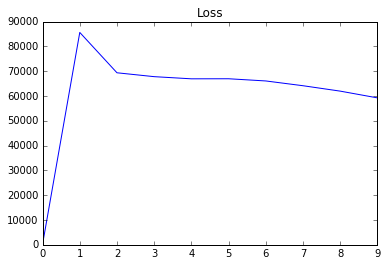

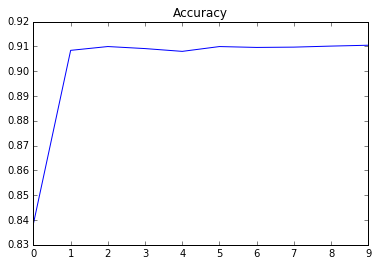

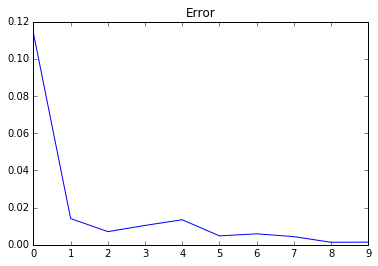

In [17]:
plt.plot(loss)
plt.title("Loss")
plt.show()

plt.plot(arr)
plt.title("Accuracy")
plt.show()

plt.plot(err)
plt.title("Error")
plt.show()

## Evaluation Dropout p=0.2

In [18]:
loss, arr, err = train(train_images, train_labels, test_images, test_labels, drop=True)

i: 0, test_acc: 0.447463291713, loss: 567.209125, gen_err: 0.0179167131924
i: 1000, test_acc: 0.856356004987, loss: 219173.085518, gen_err: 0.00782963447985
i: 2000, test_acc: 0.898220803397, loss: 114693.784225, gen_err: 0.0173809112101
i: 3000, test_acc: 0.903602360317, loss: 91568.9894268, gen_err: 0.0127009397348
i: 4000, test_acc: 0.905606798444, loss: 86495.5889871, gen_err: 0.0107104119895
i: 5000, test_acc: 0.908388061523, loss: 80753.8206501, gen_err: 0.0111960715508
i: 6000, test_acc: 0.909368504116, loss: 76939.0691891, gen_err: 0.0107466621391
i: 7000, test_acc: 0.908731842041, loss: 75497.5068856, gen_err: 0.00885450985677
i: 8000, test_acc: 0.909545789446, loss: 71575.6722047, gen_err: 0.00875347852961
i: 9000, test_acc: 0.909982256208, loss: 75875.9919271, gen_err: 0.00984869973416


In [19]:
print("Generalization error: {}, Test Accuracy: {}".format(np.mean(err), np.max(arr)))

Generalization error: 0.0115938032417, Test Accuracy: 0.909982256208


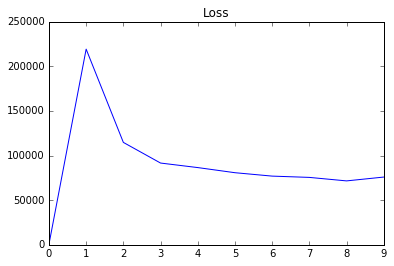

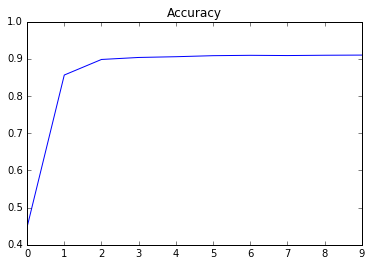

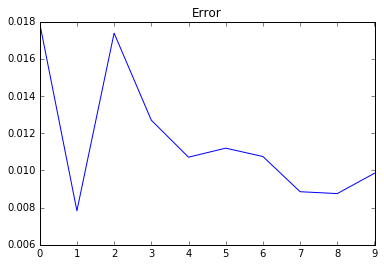

In [20]:
plt.plot(loss)
plt.title("Loss")
plt.show()

plt.plot(arr)
plt.title("Accuracy")
plt.show()

plt.plot(err)
plt.title("Error")
plt.show()

## Evaluation L2 with $\lambda = 0.01$

In [21]:
loss, arr, err = train(train_images, train_labels, test_images, test_labels, L2=True)

i: 0, test_acc: 0.129757494245, loss: 153.6799375, gen_err: 0.061526116933
i: 1000, test_acc: 0.909274989537, loss: 95767.208541, gen_err: 0.0109406398605
i: 2000, test_acc: 0.909834398542, loss: 82757.136498, gen_err: 0.00448150334268
i: 3000, test_acc: 0.909955487932, loss: 78926.3432734, gen_err: 0.00565015067185
i: 4000, test_acc: 0.908696354457, loss: 75186.0781777, gen_err: 0.00783323002491
i: 5000, test_acc: 0.910090462821, loss: 74270.3404395, gen_err: 0.00207596919982
i: 6000, test_acc: 0.908568725586, loss: 73588.7671543, gen_err: 0.0077570427157
i: 7000, test_acc: 0.910396401542, loss: 75120.1497578, gen_err: 0.00170396913232
i: 8000, test_acc: 0.910286821638, loss: 75708.4697051, gen_err: 0.00266067670563
i: 9000, test_acc: 0.910563267299, loss: 71612.8136445, gen_err: 0.000299435445596


In [22]:
print("Generalization error: {}, Test Accuracy: {}".format(np.mean(err), np.max(arr)))

Generalization error: 0.0104928734032, Test Accuracy: 0.910563267299


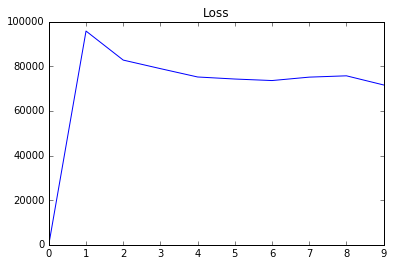

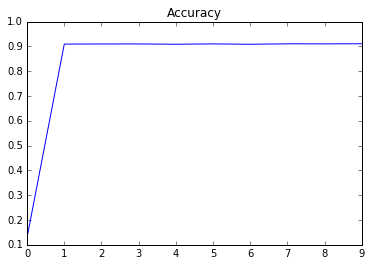

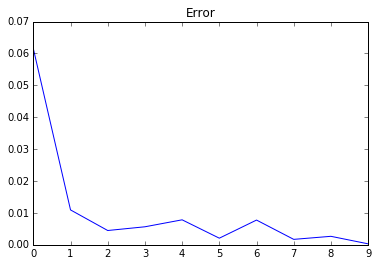

In [23]:
plt.plot(loss)
plt.title("Loss")
plt.show()

plt.plot(arr)
plt.title("Accuracy")
plt.show()

plt.plot(err)
plt.title("Error")
plt.show()